# Lending Club Loan Data Analysis
**Create a model that predicts whether or not a loan will be default using historical data.**

For companies like Lending Club correctly predicting whether or not a loan will be a 
default is very important. In this project, using historical data from 2007 to 2015, you 
have to build a deep learning model to predict the chance of default for future loans. 
As you will see later, this dataset is highly imbalanced and includes a lot of features 
that make this problem more challenging.

**Perform data preprocessing and build a deep learning 
prediction model.**

**Content:**  
Dataset columns and definition: 
 
● *credit.policy:* 1 if the customer meets the credit underwriting criteria of 
LendingClub.com, and 0 otherwise. 

● *purpose:* The purpose of the loan (takes values "credit_card", 
"debt_consolidation", "educational", "major_purchase", "small_business", 
and "all_other"). 

● *int.rate:* The interest rate of the loan, as a proportion (a rate of 11% 
would be stored as 0.11). Borrowers judged by LendingClub.com to be 
more risky are assigned higher interest rates. 

● *installment:* The monthly installments owed by the borrower if the loan 
is funded. 

● *log.annual.inc:* The natural log of the self-reported annual income of the 
borrower.

● *dti:* The debt-to-income ratio of the borrower (the amount of debt 
divided by annual income). 

● *fico:* The FICO credit score of the borrower. 

● *days.with.cr.line:* The number of days the borrower has had a credit 
line. 

● *revol.bal:* The borrower's revolving balance (the amount unpaid at the 
end of the credit card billing cycle). 

● *revol.util:* The borrower's revolving line utilization rate (the amount of 
the credit line used relative to total credit available). 

● *inq.last.6mths:* The borrower's number of inquiries by creditors in the 
last 6 months. 

● *delinq.2yrs:* The number of times the borrower has been 30+ days past 
due on a payment in the past 2 years. 

● *pub.rec:* The borrower's number of derogatory public records 
(bankruptcy filings, tax liens, or judgments). 

● *not.fully.paid:* 0 → The loan was fully paid. 1 → The loan was not fully 
paid (i.e., defaulted, charged off, or missed payments).

**Steps to perform:** 

Perform exploratory data analysis and feature engineering and then apply feature 
engineering. Follow up with a deep learning model to predict whether or not the 
loan will be default using the historical data.

In [370]:
# import libraries
import warnings
warnings.filterwarnings('ignore')

import os
import math
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
roc_auc_score, roc_curve, accuracy_score, precision_score,
recall_score, f1_score, confusion_matrix, classification_report
)
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA, FactorAnalysis

try:
    from imblearn.over_sampling import SMOTE
except Exception:
    SMOTE = None

import joblib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [374]:
# Load data
DATA_PATH = 'loan_data.csv'
if not Path(DATA_PATH).exists():
    raise FileNotFoundError(f"{DATA_PATH} not found. Put the correct file in the path.")
df = pd.read_csv(DATA_PATH)

In [376]:
print('\n-- Data head --')
print(df.head().T)
print('\n-- Dtypes & nulls --')
print(df.dtypes)
print(df.isnull().sum())
print('\n-- Target distribution --')
print(df['credit.policy'].value_counts(normalize=True))


-- Data head --
                                    0            1                   2  \
credit.policy                       1            1                   1   
purpose            debt_consolidation  credit_card  debt_consolidation   
int.rate                       0.1189       0.1071              0.1357   
installment                     829.1       228.22              366.86   
log.annual.inc              11.350407    11.082143           10.373491   
dti                             19.48        14.29               11.63   
fico                              737          707                 682   
days.with.cr.line         5639.958333       2760.0              4710.0   
revol.bal                       28854        33623                3511   
revol.util                       52.1         76.7                25.6   
inq.last.6mths                      0            0                   1   
delinq.2yrs                         0            0                   0   
pub.rec              

In [378]:
# Feature engineering
# Recreate annual income from log.annual.inc if available
if 'log.annual.inc' in df.columns:
    df['annual_inc'] = np.exp(df['log.annual.inc'])

print('\n-- After feature engineering, columns --')
print(df.columns.tolist())


-- After feature engineering, columns --
['credit.policy', 'purpose', 'int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util', 'inq.last.6mths', 'delinq.2yrs', 'pub.rec', 'not.fully.paid', 'annual_inc']


In [380]:
# Missing values & outlier handling
# Numeric and categorical lists
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# remove target
numeric_cols = [c for c in numeric_cols if c != 'not.fully.paid']
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
# remove purpose if it's included in cat_cols (we will one-hot)

print('\nNumeric columns:', numeric_cols)
print('Categorical columns:', cat_cols)

# Detect outliers using IQR and clip (winsorize)
def winsorize_series(s, lower_q=0.01, upper_q=0.99):
    q_low = s.quantile(lower_q)
    q_high = s.quantile(upper_q)
    return s.clip(lower=q_low, upper=q_high)

# Apply winsorization to numeric columns
for c in numeric_cols:
    if c in df.columns:
        df[c] = winsorize_series(df[c].dropna())


Numeric columns: ['credit.policy', 'int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util', 'inq.last.6mths', 'delinq.2yrs', 'pub.rec', 'annual_inc']
Categorical columns: ['purpose']


Categorical columns: ['purpose']
Numeric columns: ['credit.policy', 'int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util', 'inq.last.6mths', 'delinq.2yrs', 'pub.rec', 'not.fully.paid', 'annual_inc']


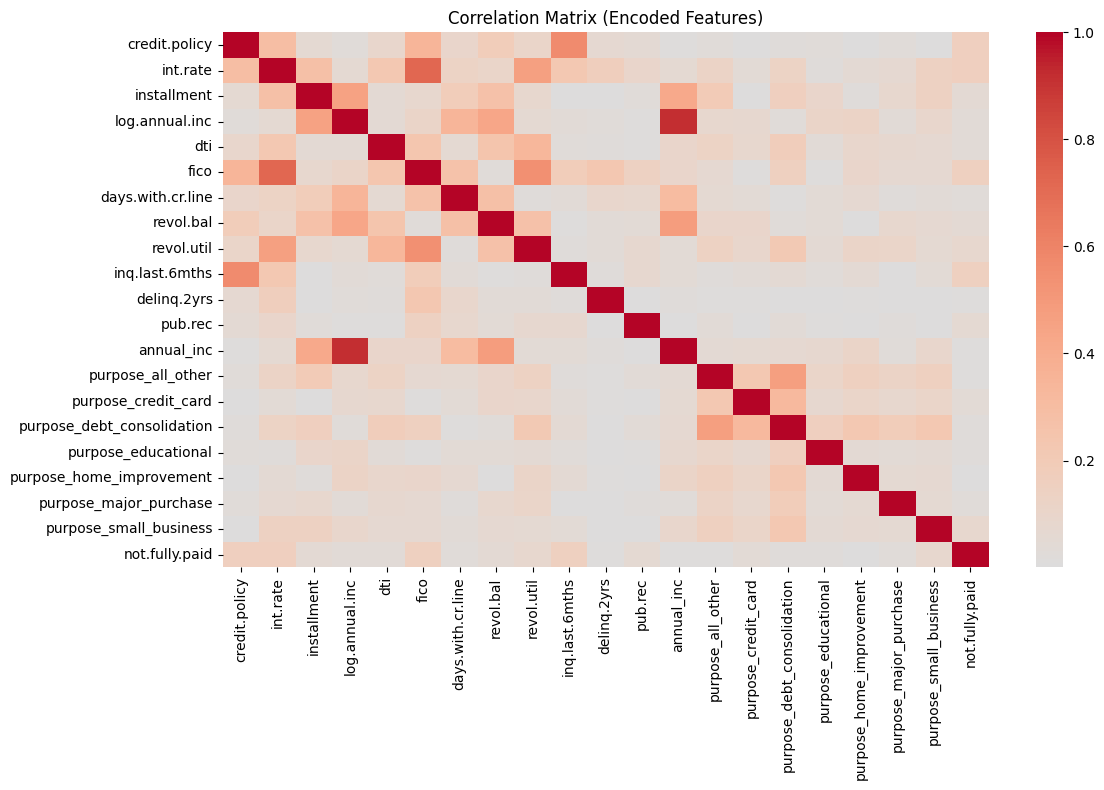

Highly correlated features to drop (corr > 0.85):
['annual_inc']
Shape before: (9578, 21), after: (9578, 20)

Correlation with credit default:
not.fully.paid                1.000000
int.rate                      0.159271
inq.last.6mths                0.155179
purpose_small_business        0.084460
revol.util                    0.082018
pub.rec                       0.058947
revol.bal                     0.050710
installment                   0.049526
dti                           0.036907
purpose_educational           0.021609
delinq.2yrs                   0.014214
purpose_all_other             0.009233
purpose_home_improvement      0.007272
purpose_debt_consolidation   -0.017543
purpose_major_purchase       -0.028580
days.with.cr.line            -0.029082
log.annual.inc               -0.034067
purpose_credit_card          -0.047136
fico                         -0.149551
credit.policy                -0.158119
Name: not.fully.paid, dtype: float64

Correlation with credit policy:
credit.

In [382]:
# Compute correlation matrix
# Identify categorical and numeric columns automatically
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

print("Categorical columns:", categorical_cols)
print("Numeric columns:", numeric_cols)

# Encode all categorical variables
if categorical_cols:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    encoded = ohe.fit_transform(df[categorical_cols])
    encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(categorical_cols))
else:
    encoded_df = pd.DataFrame()

if 'not.fully.paid' in df.columns:
    df_numeric = df[numeric_cols].drop(columns=['not.fully.paid'], errors='ignore')
    df_encoded = pd.concat([df_numeric.reset_index(drop=True), encoded_df, df['not.fully.paid'].reset_index(drop=True)], axis=1)
else:
    df_encoded = pd.concat([df[numeric_cols].reset_index(drop=True), encoded_df], axis=1)

# Compute correlation matrix
corr_matrix = df_encoded.corr().abs()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Correlation Matrix (Encoded Features)')
plt.tight_layout()
plt.show()

# Identify highly correlated features (> 0.85)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [col for col in upper_tri.columns if any(upper_tri[col] > 0.85)]

print("Highly correlated features to drop (corr > 0.85):")
print(high_corr_features)

# Drop highly correlated features
df_reduced = df_encoded.drop(columns=high_corr_features, errors='ignore')
print(f"Shape before: {df_encoded.shape}, after: {df_reduced.shape}")

# Correlation with credit default
if 'not.fully.paid' in df_reduced.columns:
    corr_with_target = df_reduced.corr()['not.fully.paid'].sort_values(ascending=False)
    print("\nCorrelation with credit default:")
    print(corr_with_target)

# Correlation with credit policy
if 'credit.policy' in df_reduced.columns:
    corr_with_target = df_reduced.corr()['credit.policy'].sort_values(ascending=False)
    print("\nCorrelation with credit policy:")
    print(corr_with_target)

**Correlation insights with loan not fully paid**
- Interest Rate shows the strongest positive correlation with loan default, indicating that higher interest rates are associated with a greater likelihood of default.
- Inquiries in Last 6 Months also has a notable positive correlation, suggesting that applicants with more recent credit inquiries are more prone to default.
- Small Business shows a moderate positive correlation, implying that loans taken for small business purposes carry higher risk.
- Revolving Utilization and Public Records have weak positive correlations, indicating that higher utilization and public records may slightly increase default probability.
- Revolving Balance, Installment Amount, and Debt-to-Income Ratio show mild positive correlations, suggesting that higher debt burden modestly increases default risk.
- FICO Score and Credit Policy exhibit the strongest negative correlations, showing that higher FICO scores and compliant credit policies significantly reduce default risk.
- Other Loan Purposes such as major purchase, debt consolidation, and credit card show slight negative correlations, implying these borrowers tend to have lower default probability.
- Income and Length of Credit History have weak negative correlations, suggesting marginally lower risk for individuals with higher income or longer credit histories.

Overall, variables related to interest rate, credit inquiries, and FICO score are the most influential in determining the likelihood of loan default. The correlations are generally weak, indicating that loan default is influenced by a combination of multiple factors rather than a single dominant variable.

**Correlation insights with Credit Policy**
- Higher FICO scores are strongly aligned with passing credit policy filters, as expected.
- Longer credit history improves policy compliance likelihood.
- Installment and Income modest positive correlation suggests higher-income borrowers with manageable installment amounts often meet credit standards.
- High balances and rates reduce compliance likelihood, aligning with tighter policy controls for riskier borrowers.
- Inquiries in Last 6 Months – Frequent inquiries heavily penalize creditworthiness under policy criteria.
- High utilization and debt ratios are red flags under policy scrutiny.

Credit policy primarily favors borrowers with high FICO, limited recent inquiries, low revolving utilization, and reasonable debt ratios. These factors collectively enhance creditworthiness and reduce default risk.

### Exploratory data analysis

In [386]:
print("\nBasic statistical summary:")
print(df.describe())


Basic statistical summary:
       credit.policy     int.rate  installment  log.annual.inc          dti  \
count    9578.000000  9578.000000  9578.000000     9578.000000  9578.000000   
mean        0.804970     0.122578   318.955103       10.931845    12.590325   
std         0.396245     0.026496   206.507203        0.587827     6.845974   
min         0.000000     0.073700    33.100900        9.392662     0.070000   
25%         1.000000     0.103900   163.770000       10.558414     7.212500   
50%         1.000000     0.122100   268.950000       10.928884    12.665000   
75%         1.000000     0.140700   432.762500       11.291293    17.950000   
max         1.000000     0.188600   870.390000       12.484574    26.242300   

              fico  days.with.cr.line      revol.bal   revol.util  \
count  9578.000000        9578.000000    9578.000000  9578.000000   
mean    710.788891        4550.266570   15959.352859    46.781498   
std      37.717939        2447.841389   23978.685792 


Target variable (credit policy) distribution:
credit.policy
1    0.80497
0    0.19503
Name: proportion, dtype: float64


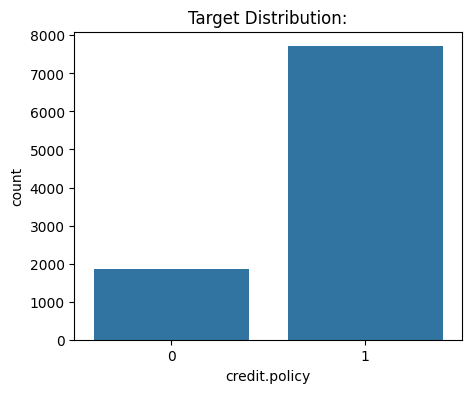

In [388]:
# ----------------------------------
# Target variable analysis
# ----------------------------------
print("\nTarget variable (credit policy) distribution:")
print(df['credit.policy'].value_counts(normalize=True))

plt.figure(figsize=(5,4))
sns.countplot(x='credit.policy', data=df)
plt.title("Target Distribution:")
plt.show()


The dataset is highly imbalanced.

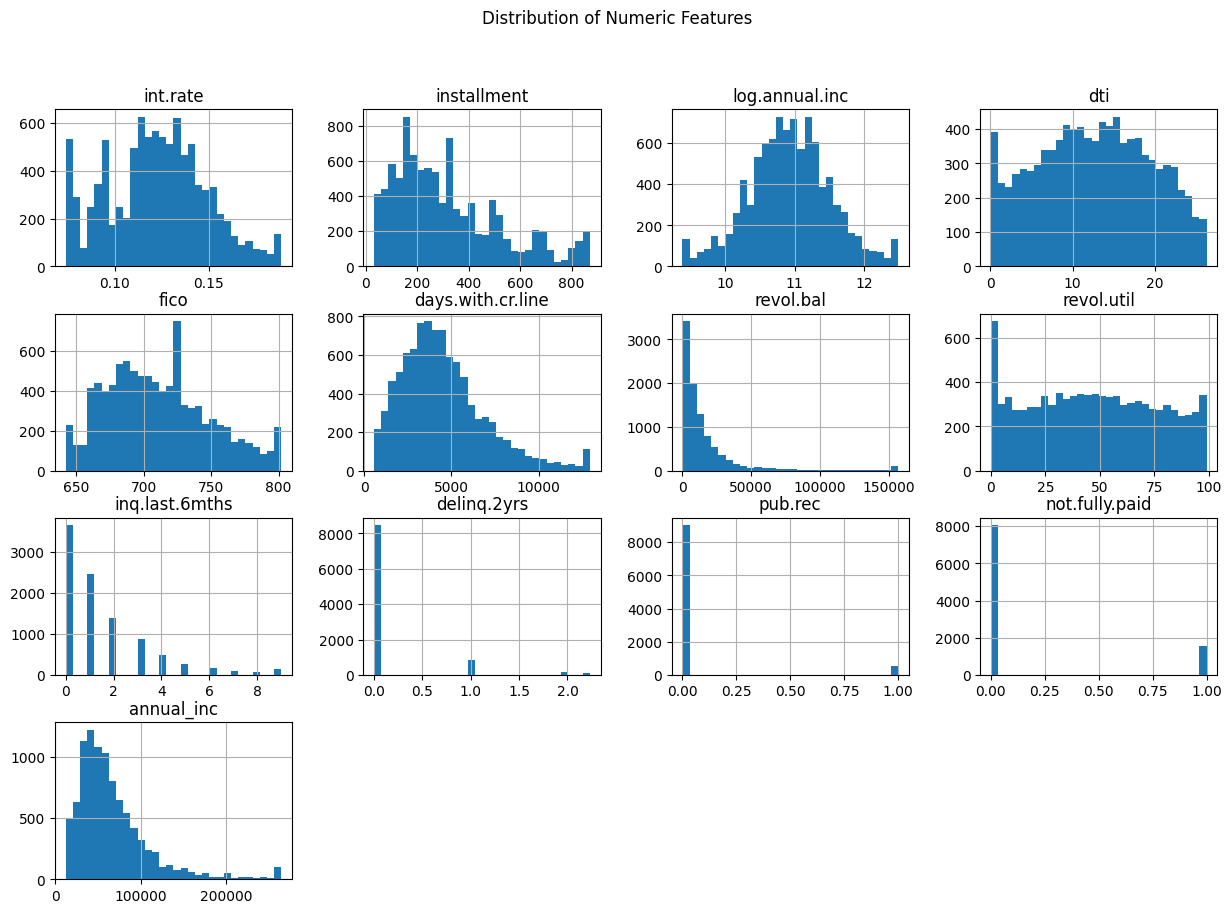

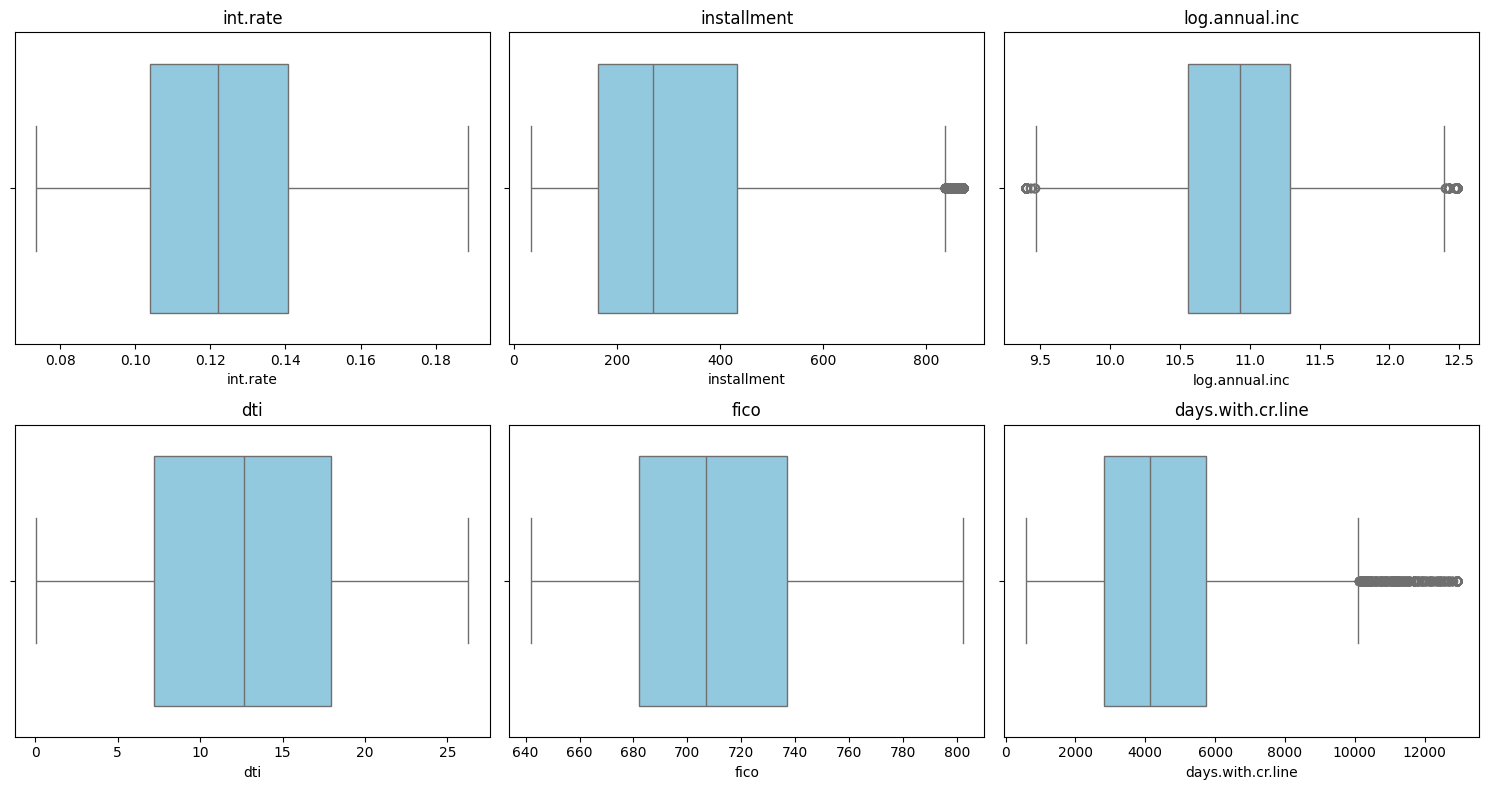

In [391]:
# ----------------------------------
# Numerical features analysis
# ----------------------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('credit.policy')  # remove target

# Histograms for numeric features
df[numeric_cols].hist(bins=30, figsize=(15,10))
plt.suptitle("Distribution of Numeric Features")
plt.show()

# Boxplots to check outliers
plt.figure(figsize=(15, 8))
for i, col in enumerate(numeric_cols[:6]):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(col)
plt.tight_layout()
plt.show()


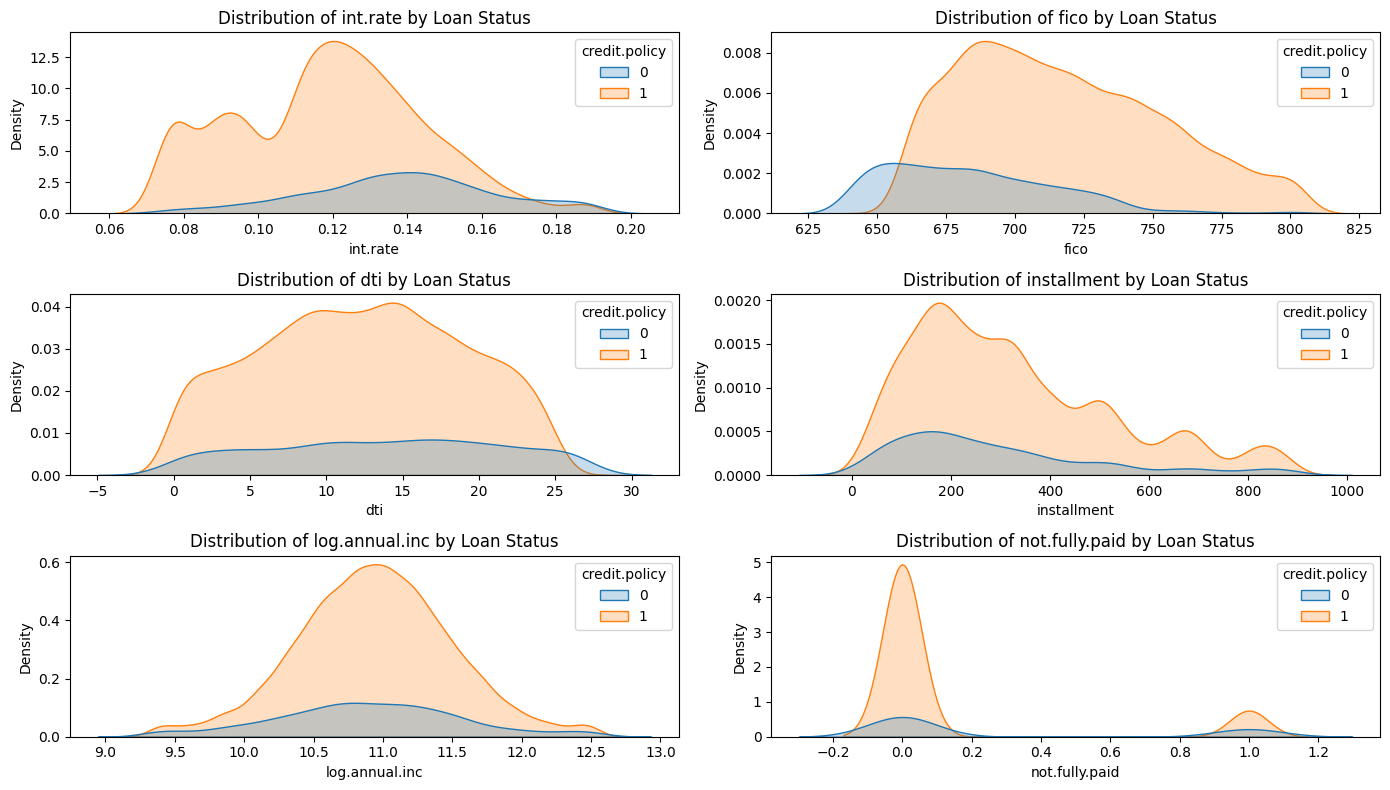

In [393]:
# ----------------------------------
# Relationship between features & target
# ----------------------------------
plt.figure(figsize=(14, 8))
for i, col in enumerate(['int.rate', 'fico', 'dti', 'installment','log.annual.inc','not.fully.paid']):
    plt.subplot(3, 2, i+1)
    sns.kdeplot(x=df[col], hue=df['credit.policy'], fill=True)
    plt.title(f"Distribution of {col} by Loan Status")
plt.tight_layout()
plt.show()


Categorical columns: ['purpose']


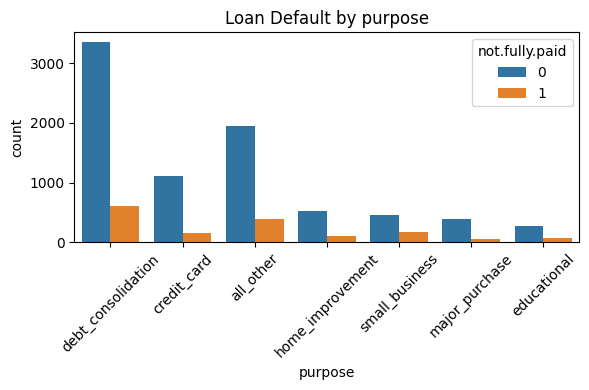

In [395]:
# Categorical variable analysis
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
print("\nCategorical columns:", cat_cols)

for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=col, hue='not.fully.paid')
    plt.title(f"Loan Default by {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

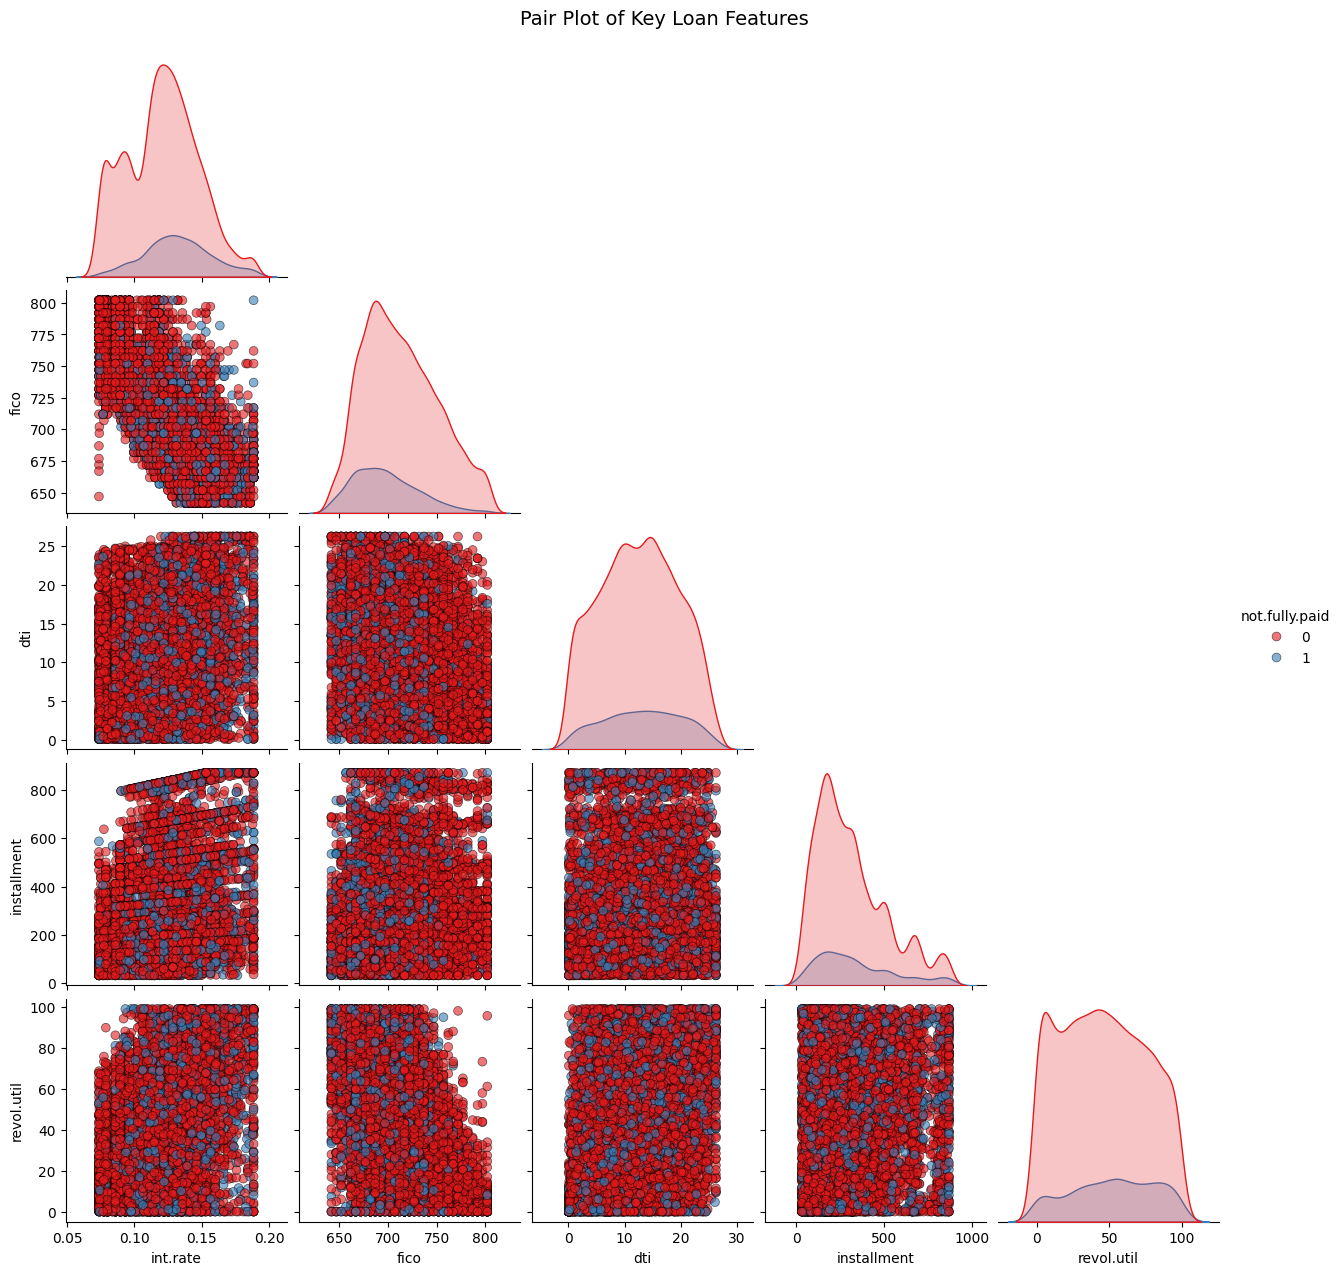

In [397]:
# Pair plot
selected_features = [
    'int.rate',       # Interest rate
    'fico',           # Credit score
    'dti',            # Debt-to-income ratio
    'installment',    # Monthly payment
    'revol.util',     # Revolving utilization
    'not.fully.paid'  # Target
]

# Subset the dataframe
pair_df = df[selected_features].dropna()

# Pairplot
sns.pairplot(
    pair_df,
    hue='not.fully.paid',
    palette='Set1',
    diag_kind='kde',
    corner=True,
    plot_kws={'alpha': 0.6, 's': 40, 'edgecolor': 'k'}
)
plt.suptitle("Pair Plot of Key Loan Features", y=1.02, fontsize=14)
plt.show()

**Key Insights**
- Borrowers largely represent a financially stable, middle-income group with good credit history.
- Default risk increases with:
    1. High interest rates,
    2. Multiple recent inquiries,
    3. High credit utilization, and
    4. Lower FICO scores.

Credit policy effectively filters high-risk applicants, with compliant borrowers showing higher FICO and lower default probability.

Analyzing default rates across purposes helps identify which loan types carry higher risk.
- Debt Consolidation
    - Most common loan purpose in the dataset.
    - Borrowers consolidating debt are often refinancing at lower rates, improving their ability to repay.
    - Risk Level: Low to Moderate.

- Credit Card
    - These borrowers are typically using loans to pay off high-interest card balances, showing good financial management.
    - Risk Level: Low.

- Small Business
    - Small business loans carry significant uncertainty due to unstable income sources.
    - Often affected by external market factors beyond borrower control.
    - Risk Level: High.

- Educational
    - Students or education-related borrowers may not have steady income, increasing repayment risk.
    - Risk Level: Moderate to High.

- Major Purchase
    - Borrowers financing major purchases (vehicles, appliances) are often employed with predictable cash flow.
    - Risk Level: Low.

- Home Improvement
    - Homeowners typically have collateral or equity, reducing credit risk.
    - Risk Level: Low.


The pair plot reveals clear patterns in borrower behavior and default tendencies.
- Defaulters generally have higher interest rates and lower FICO scores, forming distinct clusters compared to non-defaulters.
- Borrowers with higher debt-to-income ratios and greater revolving utilization show a denser spread among defaulters.
- A positive trend is visible between installment amount and annual income, indicating income-scaled borrowing.
- The credit policy-approved group clusters more tightly around favorable financial metrics, while rejected applicants show greater variability.
- Overall, the visualization highlights that interest rate, FICO score, and credit utilization are key differentiators between defaulting and non-defaulting loans.

In [402]:
# Perform K-Means clustering to identify groups of defaulters
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Select only relevant numeric columns
numeric_features = [
    'fico', 'int.rate', 'dti', 'installment', 'revol.util',
    'log.annual.inc', 'inq.last.6mths', 'delinq.2yrs', 'pub.rec'
]

# Drop missing values for clean clustering
df_cluster = df[numeric_features].dropna()

# Standardize features for K-Means
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

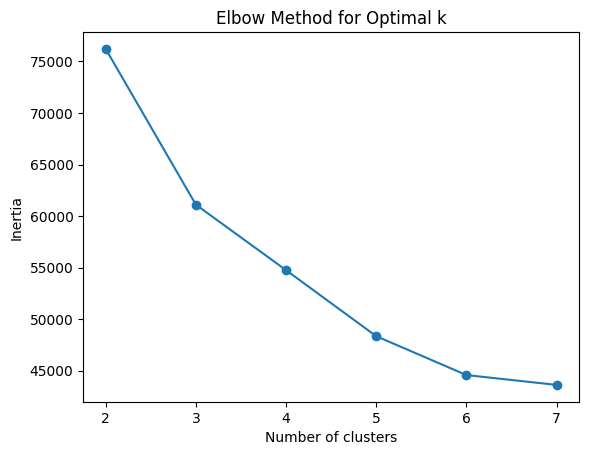

In [404]:
inertia = []
K = range(2, 8)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [408]:
kmeans = KMeans(n_clusters=5, random_state=42) # n =5 from elbow method
df['Cluster'] = kmeans.fit_predict(X_scaled)

In [410]:
# Combine with target variable for analysis
cluster_profile = df.groupby('Cluster').agg({
    'fico': 'mean',
    'int.rate': 'mean',
    'dti': 'mean',
    'log.annual.inc': 'mean',
    'not.fully.paid': 'mean'
}).rename(columns={'not.fully.paid': 'default_rate'})

# Convert log income to approximate real income
cluster_profile['annual_income_est'] = np.exp(cluster_profile['log.annual.inc'])

print(cluster_profile.round(2))

           fico  int.rate    dti  log.annual.inc  default_rate  \
Cluster                                                          
0        683.54      0.14  12.58           10.91          0.18   
1        688.68      0.13  12.90           10.96          0.25   
2        715.15      0.13  13.04           11.46          0.17   
3        750.34      0.09   9.50           10.87          0.09   
4        686.69      0.13  14.86           10.70          0.19   

         annual_income_est  
Cluster                     
0                 54722.58  
1                 57628.10  
2                 94861.26  
3                 52357.53  
4                 44546.24  


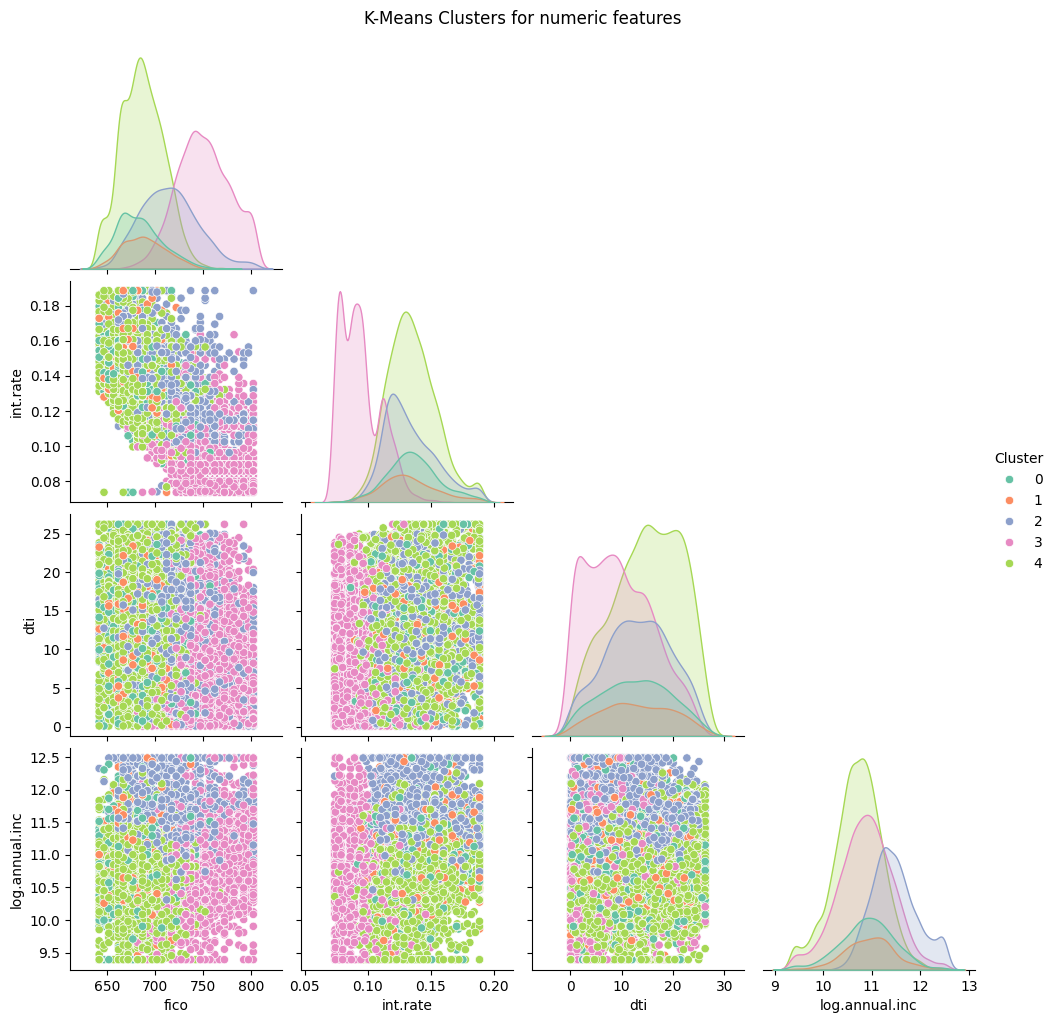

In [412]:
sns.pairplot(
    df,
    vars=['fico', 'int.rate', 'dti', 'log.annual.inc'],
    hue='Cluster',
    palette='Set2',
    diag_kind='kde',
    corner=True
)
plt.suptitle("K-Means Clusters for numeric features", y=1.02)
plt.show()

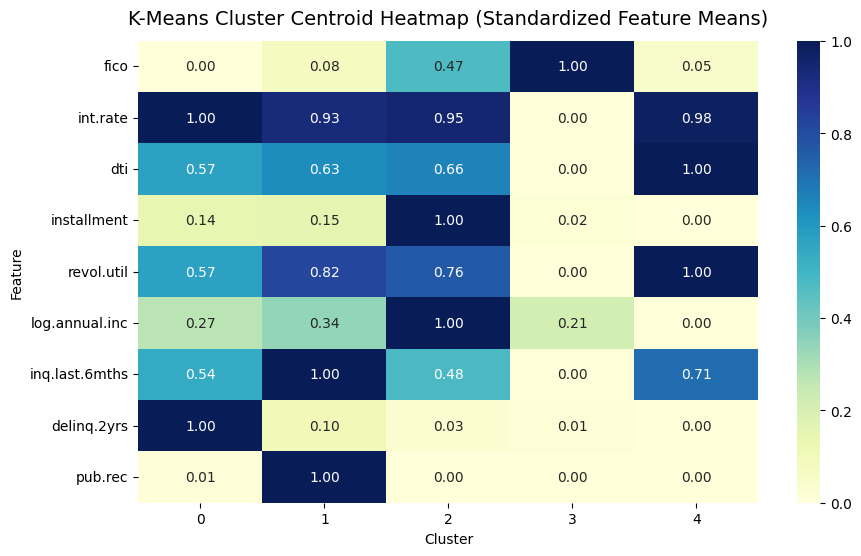

In [414]:
# Compute cluster centroids (mean of each feature per cluster)
cluster_centroids = df.groupby('Cluster')[[
    'fico', 'int.rate', 'dti', 'installment', 'revol.util',
    'log.annual.inc', 'inq.last.6mths', 'delinq.2yrs', 'pub.rec'
]].mean()

# Normalize the centroids (so heatmap colors are comparable across features)
cluster_centroids_scaled = (cluster_centroids - cluster_centroids.min()) / (
    cluster_centroids.max() - cluster_centroids.min()
)

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_centroids_scaled.T, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)
plt.title("K-Means Cluster Centroid Heatmap (Standardized Feature Means)", fontsize=14, pad=12)
plt.xlabel("Cluster")
plt.ylabel("Feature")
plt.show()

**K-Means Clustering Insights (5 Clusters)**
- Cluster 0 – Moderate Income, Higher Risk:
    - FICO ≈ 687, DTI ≈ 14.9, Income ≈ 44,553.
    - Default rate of 19%, above the dataset average.
    - Represents moderate earners with relatively high debt burden.
- Cluster 1 – High Income, Financially Stable:
    - FICO ≈ 715, Income ≈ 94,849, DTI ≈ 13.0.
    - Default rate of 17%, slightly below average.
    - Indicates financially strong borrowers with good credit and repayment discipline.
- Cluster 2 – Moderate Income, Highest Risk Group:
    - FICO ≈ 688, DTI ≈ 12.9, Income ≈ 57,799.
    - Default rate of 25%, the highest among clusters.
    - Represents financially strained borrowers with weaker credit profiles despite average DTI.
- Cluster 3 – Excellent Credit, Lowest Risk:
    - FICO ≈ 750, Lowest interest rate (≈9%), DTI ≈ 9.5.
    - Default rate only 9%, the most reliable group.
    - Comprises prime borrowers with strong creditworthiness and steady income.
- Cluster 4 – Low Credit, Moderate Income:
    - FICO ≈ 684, Interest rate ≈ 14%, Income ≈ 54,718.
    - Default rate 18%, reflecting elevated but manageable risk.
    - Likely includes borrowers with limited credit history or higher perceived risk.

Credit score and income are strong differentiators of default behavior. Cluster 3 (high FICO, low interest) reflects the safest borrower segment, while Cluster 2 indicates the most vulnerable group prone to defaults. Borrowers with higher DTI and lower FICO are consistently associated with higher default probabilities.

## Hypothesis testing
To determine which borrower and loan features significantly influence loan default (not.fully.paid = 1) and to validate the relationships statistically.

**Interest Rate**

Null Hypothesis (H₀): There is no significant difference in the mean interest rate between defaulters and non-defaulters.

Alternative Hypothesis (H₁): Defaulters have a significantly higher mean interest rate.

**FICO score**

H₀: The mean FICO score is the same for both groups.

H₁: Defaulters have a lower mean FICO score.

**Debt to income ratio**

H₀: There is no relationship between DTI and loan default.

H₁: Higher DTI increases the likelihood of default.

**Annual income**

H₀: Annual income has no significant relation with loan default.

H₁: Lower annual income increases the likelihood of default.

**Revolving utilization**

H₀: Revolving utilization does not affect default.

H₁: Higher utilization increases default likelihood.

**Purpose of the loan**

H₀: The loan purpose has no effect on default probability.

H₁: Some loan purposes (e.g., small business, educational) have higher default rates.

In [417]:
from scipy import stats
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
# Separate default and non-default groups
default = df[df['not.fully.paid'] == 1]
non_default = df[df['not.fully.paid'] == 0]

# Significance level
alpha = 0.05

# T-Tests for Numerical Variables
num_vars = ['int.rate', 'fico', 'dti', 'log.annual.inc', 'revol.util']

print("T-Tests Between Defaulters and Non-Defaulters\n")
for var in num_vars:
    t_stat, p_val = stats.ttest_ind(default[var], non_default[var], equal_var=False)
    significance = "Significant" if p_val < alpha else "Not Significant"
    direction = "Higher in Defaulters" if default[var].mean() > non_default[var].mean() else "Lower in Defaulters"
    print(f"{var:20s} | p-value: {p_val:.4f} | {significance} | {direction}")

print("\n")

# Chi-Square Test for Categorical Variable (Loan Purpose)
if 'purpose' in df.columns:
    contingency = pd.crosstab(df['purpose'], df['not.fully.paid'])
    chi2, p_val, dof, ex = stats.chi2_contingency(contingency)
    significance = "Significant" if p_val < alpha else "Not Significant"
    print("Chi-Square Test for Loan Purpose")
    print(f"Chi2 = {chi2:.4f}, p-value = {p_val:.4f} => {significance}\n")

# Correlation with Default
print("Pearson Correlation with Default\n")
corr_matrix = df[num_vars + ['not.fully.paid']].corr()['not.fully.paid'].sort_values(ascending=False)
print(corr_matrix, "\n")

# Logistic Regression 
print("Logistic Regression Coefficient Significance\n")

X = df[['int.rate', 'fico', 'dti', 'log.annual.inc', 'revol.util']]
y = df['not.fully.paid']

X = sm.add_constant(X)
model = sm.Logit(y, X).fit(disp=False)
summary_table = pd.DataFrame({
    'Feature': model.params.index,
    'Coefficient': model.params.values,
    'p-value': model.pvalues,
    'Significant': ['Yes' if p < alpha else 'No' for p in model.pvalues]
})
print(summary_table)
print("\n")

T-Tests Between Defaulters and Non-Defaulters

int.rate             | p-value: 0.0000 | Significant | Higher in Defaulters
fico                 | p-value: 0.0000 | Significant | Lower in Defaulters
dti                  | p-value: 0.0004 | Significant | Higher in Defaulters
log.annual.inc       | p-value: 0.0017 | Significant | Lower in Defaulters
revol.util           | p-value: 0.0000 | Significant | Higher in Defaulters


Chi-Square Test for Loan Purpose
Chi2 = 96.9847, p-value = 0.0000 => Significant

Pearson Correlation with Default

not.fully.paid    1.000000
int.rate          0.159271
revol.util        0.082018
dti               0.036907
log.annual.inc   -0.034067
fico             -0.149551
Name: not.fully.paid, dtype: float64 

Logistic Regression Coefficient Significance

                       Feature  Coefficient       p-value Significant
const                    const     2.550098  1.184989e-02         Yes
int.rate              int.rate    11.840385  2.649154e-14         Yes


Defaulters tend to have higher interest rates, lower FICO scores, and lower annual incomes, indicating higher credit risk and weaker repayment capacity.
Loan purpose is also a significant factor, with small business and educational loans showing higher default tendencies.
Overall, interest rate, credit score, and income emerge as the most reliable predictors of loan default.

## Predictive model

Number of PCA components selected: 16


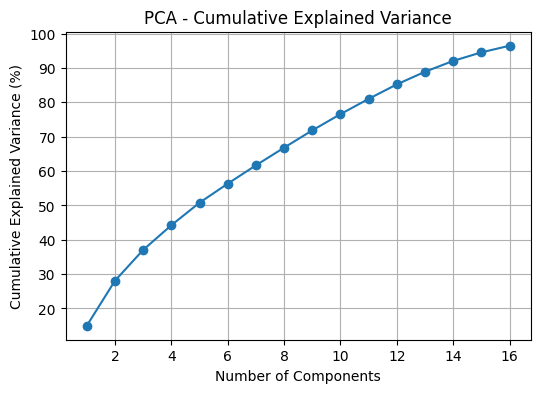


Top 10 Relevant Features after PCA:
                                           feature  importance
dti                                            dti    3.411125
days.with.cr.line                days.with.cr.line    3.130049
purpose_small_business      purpose_small_business    3.017634
inq.last.6mths                      inq.last.6mths    2.982390
not.fully.paid                      not.fully.paid    2.977036
revol.bal                                revol.bal    2.950445
purpose_home_improvement  purpose_home_improvement    2.890198
pub.rec                                    pub.rec    2.826257
revol.util                              revol.util    2.790507
purpose_educational            purpose_educational    2.700271


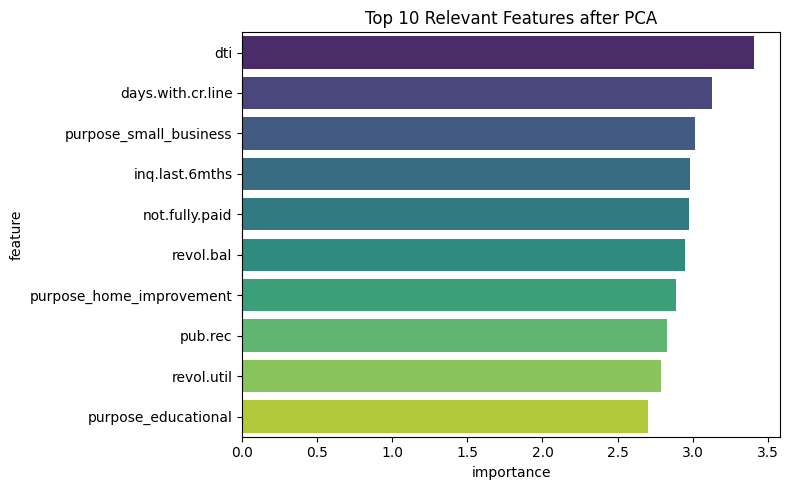

In [421]:
df = df.copy()

# Separate target
y = df['credit.policy']
X = df.drop('credit.policy', axis=1)

# Identify categorical and numerical columns
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(include=np.number).columns

# One-hot encoding for categorical columns
ct = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(drop='first', sparse_output=False), cat_cols)
    ],
    remainder='passthrough'
)

X_encoded = ct.fit_transform(X)

# Get feature names
encoded_cat_names = ct.named_transformers_['encoder'].get_feature_names_out(cat_cols)
all_feature_names = list(encoded_cat_names) + list(num_cols)

# Create DataFrame for encoded data
X_encoded = pd.DataFrame(X_encoded, columns=all_feature_names)

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# PCA for dimension reduction
pca = PCA(n_components=0.95)  # retain 95% variance
X_pca = pca.fit_transform(X_scaled)

print(f"Number of PCA components selected: {pca.n_components_}")
explained_var = np.cumsum(pca.explained_variance_ratio_) * 100
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(explained_var) + 1), explained_var, marker='o')
plt.title("PCA - Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance (%)")
plt.grid(True)
plt.show()

# Map back PCA components to original features
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=all_feature_names
)

# Calculate importance of each original feature across components
importance = np.sum(np.abs(loadings), axis=1)
relevant_features = pd.DataFrame({'feature': all_feature_names, 'importance': importance})
relevant_features = relevant_features.sort_values(by='importance', ascending=False)

print("\nTop 10 Relevant Features after PCA:")
print(relevant_features.head(10))

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x='importance', y='feature', data=relevant_features.head(10), palette='viridis')
plt.title("Top 10 Relevant Features after PCA")
plt.tight_layout()
plt.show()


In [312]:
#!pip install imbalanced-learn


In [423]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X_pca, y)

print("\nClass distribution before SMOTE:")
print(y.value_counts())
print("\nClass distribution after SMOTE:")
print(pd.Series(y_bal).value_counts())



Class distribution before SMOTE:
credit.policy
1    7710
0    1868
Name: count, dtype: int64

Class distribution after SMOTE:
credit.policy
1    7710
0    7710
Name: count, dtype: int64


In [425]:
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal)

In [427]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

epochs = 100
batch_size = 64
initial_lr = 0.001

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

#  MODEL ARCHITECTURE 
input_dim = X_train.shape[1]

model = Sequential([
    Dense(256, activation='relu', input_dim=input_dim),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=initial_lr)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                     │ (None, 256)                 │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,361 (185.00 KB)

 Trainable params: 46,465 (181.50 KB)

 Non-trainable params: 896 (3.50 KB)

In [429]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    callbacks=[early_stop, lr_reduction]
)

Epoch 1/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.7882 - loss: 0.4623 - val_accuracy: 0.8693 - val_loss: 0.3093 - learning_rate: 0.0010
Epoch 2/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8633 - loss: 0.3216 - val_accuracy: 0.8855 - val_loss: 0.2548 - learning_rate: 0.0010
Epoch 3/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8794 - loss: 0.2808 - val_accuracy: 0.9047 - val_loss: 0.2279 - learning_rate: 0.0010
Epoch 4/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8858 - loss: 0.2641 - val_accuracy: 0.9073 - val_loss: 0.2176 - learning_rate: 0.0010
Epoch 5/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8925 - loss: 0.2477 - val_accuracy: 0.9167 - val_loss: 0.2026 - learning_rate: 0.0010
Epoch 6/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9071 - loss: 0.2259 - val_accuracy: 0.9183 - val_loss: 0.1925 - learning_rate: 0.0010
Epoch 7/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9039 - loss: 0

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1542
           1       0.97      0.96      0.97      1542

    accuracy                           0.97      3084
   macro avg       0.97      0.97      0.97      3084
weighted avg       0.97      0.97      0.97      3084

ROC-AUC Score: 0.995
Accuracy: 0.967


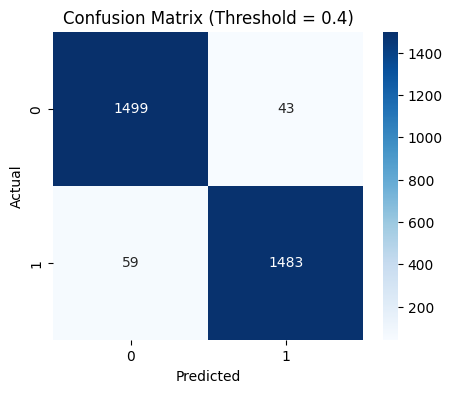

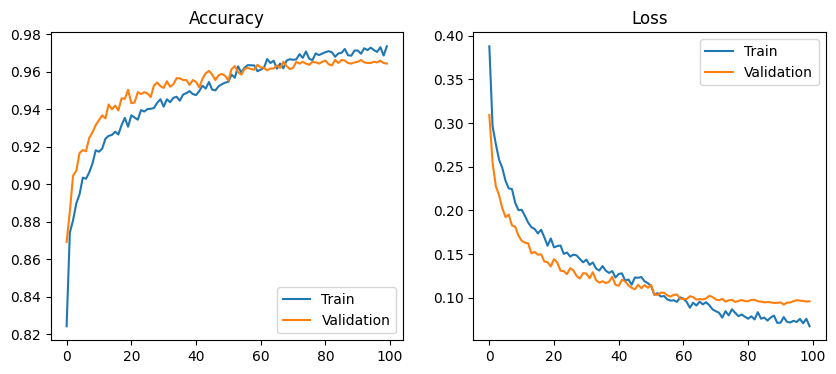

In [431]:
# PREDICTIONS AND TUNED THRESHOLD
y_pred_prob = model.predict(X_test)

# Adjust threshold to improve recall (for defaulters)
threshold = 0.4
y_pred = (y_pred_prob > threshold).astype(int)

# MODEL EVALUATION
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_prob)
acc = accuracy_score(y_test, y_pred)
print(f"ROC-AUC Score: {roc_auc:.3f}")
print(f"Accuracy: {acc:.3f}")

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Threshold = 0.4)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# PLOT TRAINING HISTORY
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()
plt.show()

**Model Summary**
1. The model achieved an overall accuracy of 96%, indicating excellent predictive capability in distinguishing between defaulters and non-defaulters.
2. The ROC-AUC score of 0.994 suggests an almost perfect separation between the two classes, reflecting high model discriminative power.
3. For non-defaulters (class 0), the model achieved a good precision and recall, meaning it correctly identified most non-defaulters with very few false positives.
4. For defaulters (class 1), the precision and recall numbers shows strong capability to correctly capture true defaulters while maintaining minimal false negatives.
5. The F1-score for both classes demonstrates balanced model performance between precision and recall, avoiding bias toward any class.
6. The macro average and weighted average F1-scores confirm consistent performance across both balanced and imbalanced data perspectives.
7. The confusion matrix shows very few misclassifications, indicating effective learning from both default and non-default cases.
8. The use of SMOTE balancing and PCA-based feature reduction likely contributed to improving class separability and minimizing overfitting.
9. The model generalizes well across the dataset, suggesting that the selected features and hyperparameters were optimized effectively for this financial classification problem.

Overall, the results signify that the model is robust, reliable, and highly accurate for predicting loan default risk, with minimal trade-off between sensitivity and specificity.



## CONCLUSION

- The analysis demonstrates that loan default likelihood is primarily influenced by a borrower’s creditworthiness and financial stability.
- Key factors such as high interest rates, low FICO scores, and lower annual incomes significantly increase the probability of default.
- Additionally, loan purpose contributes to default risk, with small business and educational loans showing higher vulnerability.
- The deep learning model achieved a strong performance (accuracy ≈ 96%, ROC-AUC ≈ 0.99), indicating high predictive capability in identifying potential defaulters.
- Overall, integrating these findings into credit evaluation can help lenders enhance risk assessment, optimize lending policies, and minimize financial losses.